In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

print("Keras {}, TensorFlow {}".format(keras.__version__, keras.backend.tf.__version__))

Using TensorFlow backend.


Keras 2.0.4, TensorFlow 1.1.0


In [3]:
img_size = 100
batch_size = 32

# Datasets

In [4]:
train_data = keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                          zoom_range=[0.97,1.05],
                                                          fill_mode='nearest',
                                                          channel_shift_range=10,
                                                          height_shift_range=0.1,
                                                          width_shift_range=0.1,
                                                          vertical_flip=True,
                                                          )
train_gen = train_data.flow_from_directory('data/train', target_size=(img_size,img_size),
                                           batch_size=batch_size, class_mode='categorical')

val_data = keras.preprocessing.image.ImageDataGenerator()
val_gen = val_data.flow_from_directory('data/val', target_size=(img_size,img_size),
                                       batch_size=batch_size, class_mode='categorical')


Found 5000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [5]:
class_names = list(train_gen.class_indices.keys())
class_names

['cats', 'dogs']

Shape of images in the batch: (32, 100, 100, 3)
First image plot:
Onehot encoding of first img target: [ 1.  0.], Class: cats


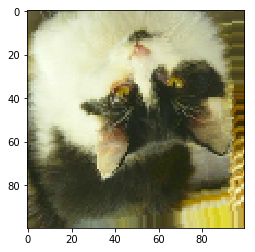

In [6]:
batch = train_gen.next()
print("Shape of images in the batch: " + str(batch[0].shape))
print("First image plot:")
img = batch[0][0].astype(np.uint8)
plt.imshow(img)
print("Onehot encoding of first img target: {}, Class: {}".format(batch[1][0], 
                                                                 class_names[np.argmax(batch[1][0])]))

# Model

In [7]:
vgg_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',
                                           classes=2, input_shape=(img_size,img_size,3))

In [8]:
model = vgg_model.output # same as model = vgg_model.layers[-1].output
model = Flatten(name='start_top')(model)
model = Dense(4096, activation='relu')(model)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)
model = Dense(4096, activation='relu')(model)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation='softmax')(model)

model = Model(inputs=vgg_model.input, outputs=model)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [9]:
for l in vgg_model.layers:
    l.trainable = False

In [10]:
# testing that model predicting works with one batch
model.predict(train_gen.next()[0][0:1])

array([[  2.80694820e-07,   9.99999762e-01]], dtype=float32)

### Training the model

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_gen, train_gen.n/train_gen.batch_size,
                      epochs=10, verbose=1, initial_epoch=0,
                      validation_data=val_gen, validation_steps=val_gen.n/val_gen.batch_size)

Epoch 1/10
157/156 [==============================] - 22s - loss: 1.4417 - acc: 0.7607 - val_loss: 1.0273 - val_acc: 0.8060
Epoch 2/10
157/156 [==============================] - 21s - loss: 0.5510 - acc: 0.8030 - val_loss: 0.8143 - val_acc: 0.8148
Epoch 3/10
157/156 [==============================] - 20s - loss: 0.4937 - acc: 0.8131 - val_loss: 0.5270 - val_acc: 0.8208
Epoch 4/10
157/156 [==============================] - 20s - loss: 0.4569 - acc: 0.8262 - val_loss: 0.3109 - val_acc: 0.8884
Epoch 5/10
157/156 [==============================] - 20s - loss: 0.4215 - acc: 0.8334 - val_loss: 1.0824 - val_acc: 0.6972
Epoch 6/10
157/156 [==============================] - 20s - loss: 0.4035 - acc: 0.8463 - val_loss: 0.4051 - val_acc: 0.8688
Epoch 7/10
157/156 [==============================] - 20s - loss: 0.3796 - acc: 0.8483 - val_loss: 0.3088 - val_acc: 0.8920
Epoch 8/10
157/156 [==============================] - 20s - loss: 0.3977 - acc: 0.8483 - val_loss: 0.3233 - val_acc: 0.8864
Epoch 9/

# Some sample predictions

In [ ]:
batch = train_gen.next()[0][0:6]
results = model.predict(batch)

In [ ]:
f = plt.figure(figsize=(12,5))
for i in range(len(results)):
    img = batch[i].astype(np.uint8)
    class_idx = np.argmax(results[i])
    score = np.max(results[i])
    img_title = "{}\n{:.4f}".format(class_names[class_idx], score)
    sp = f.add_subplot(1, len(batch), i+1)
    sp.axis('Off')
    sp.set_title(img_title, fontsize=16)
    plt.imshow(img)